In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import os
import sys
sys.path.append("C:\\Users\\Sam Yu\\Documents\\GitHub\\LiquidCrystals")

from LiquidCrystalSystem import LCSystem

In [2]:
datasets_path = "C:\\Users\\Sam Yu\\Desktop\\School\\4A\\Phys_437A_Research_Project\\datasets\\r=14\\"

particle number: 20 -> density: 0.05827505827505827
particle number: 40 -> density: 0.11655011655011654
particle number: 60 -> density: 0.17482517482517482
particle number: 80 -> density: 0.2331002331002331
particle number: 90 -> density: 0.26223776223776224
particle number: 100 -> density: 0.2913752913752914
particle number: 110 -> density: 0.32051282051282054
particle number: 118 -> density: 0.34382284382284384
particle number: 140 -> density: 0.40792540792540793
particle number: 160 -> density: 0.4662004662004662
particle number: 180 -> density: 0.5244755244755245
particle number: 200 -> density: 0.5827505827505828


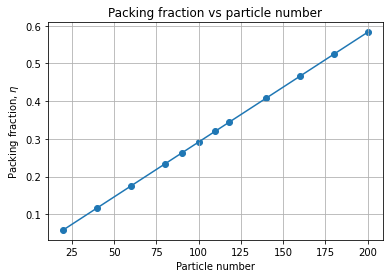

In [3]:
# calculate all the densities

R = 25 # outer radius
r = 14 # inner radius
b = 5 # long axis
a = 0.25 # short axis

Ns = [20, 40, 60, 80, 90, 100, 110, 118, 140, 160, 180, 200] # number of particles

densities = [(N*a*b/(R**2-r**2)) for N in Ns]

for i, N in enumerate(Ns):
    print(f"particle number: {Ns[i]} -> density: {densities[i]}")
plt.plot(Ns, densities)
plt.scatter(Ns, densities)
plt.xlabel("Particle number")
plt.ylabel(r"Packing fraction, $\eta$")
plt.title("Packing fraction vs particle number")
plt.grid()

In [ ]:
for _path_ in os.listdir(datasets_path):    
    print(_path_)

In [5]:
systems = dict()

for _path_ in os.listdir(datasets_path):
    
    full_path = os.path.join(datasets_path, _path_, 'instanceRun')
    
    # Simulation summary notes exists
    if os.path.exists(os.path.join(full_path, "MonteCarlo_Annulus_SimNotes.txt")):
        
        lc = LCSystem(lc_data_path=full_path)
        num_of_particles = lc.sim_params['# of Ellipse']
        systems[num_of_particles] = lc
    
    # Simulation summary notes DNE
    else:
        
        lc = LCSystem(lc_data_path=full_path)
        lc.sim_params["R"] = R
        lc.sim_params["r"] = r
        lc.sim_params["Semi Major Axis"] = b
        lc.sim_params["Semi Minor Axis"] = a
        
        num_of_particles = lc.sim_params["# of Ellipse"]
        
        systems[num_of_particles] = lc
        
        
print(sorted(systems.keys()))

[20.0, 40.0, 60.0, 80.0, 90.0, 100.0, 110.0, 118.0, 140.0, 160, 180, 200]


In [6]:
from sklearn.decomposition import PCA

In [24]:
import math
from numpy.linalg import norm

def create_feature_vectors_from_snapshot(coordinates, num_features, num_samples,
                                         feature_func=lambda x, y: abs(np.cos(x - y))):
    
    assert (num_features < len(coordinates)), \
    f"Number of features {num_features} cannot be greater than number of particles {len(coordinates)}"
    
    #print(f"Input coordinates: {coordinates}")
    
    N = len(coordinates)
    
    # set the sampling rate for nearest neighbors
    if N % num_features == 0:
        nn_sampling_number = N / num_features - 1
    else:
        nn_sampling_number = math.floor(N / num_features)
    
    #print(f"Nearest neighbor sampling number: {nn_sampling_number}")
        
    # set a random seed for reproducibility
    rng = np.random.default_rng(666)
    probe_indices = rng.choice(N, size=num_samples, replace=False)
    
    # x, y positions for particle center of masses
    spatial = [c[:2] for c in coordinates]
    # angle of long axis with respect to x for particles
    angular = [(c[-1] % np.pi) for c in coordinates]
    
    feature_vectors = []
    
    for probe_index in probe_indices:
        
        # choose the probe molecule
        probe_coord = coordinates[probe_index]
        neighbor_coords = [probe_coord]
        
        norm2 = lambda x, y: (np.array(x) - np.array(y)) @ (np.array(x) - np.array(y))
        dist_to_P = lambda x: norm2(x[:2], probe_coord[:2])
        
        nn_sorted = sorted(coordinates, key=dist_to_P)
        #print(f"Nearest neighbor sort: {nn_sorted}")
        
        # feature vector
        fv = []
        
        # add feature based on nearest neighbor distance
        for i, c in enumerate(nn_sorted):
            
            # don't add the probe molecule
            if (i > 0) and (i % nn_sampling_number) == 0:
                
                feature = feature_func(c[-1], probe_coord[-1])
                fv.append(feature)
                neighbor_coords.append(c)
            
            # Break the addition of features if total number of features is met
            if len(fv) == num_features:
                break
        
        # subtract the mean
        fv = fv - np.mean(fv)
        
        feature_vectors.append(fv)
    
    return feature_vectors, neighbor_coords

In [8]:
test_lc_system = systems[118]

print(test_lc_system.sim_params)

{'Monte Carlo steps': 2000000.0, 'R': 25.0, 'r': 14.0, 'd_pos / step size': 0.06649843596788506, 'd_ang / step size': 0.07388715107542784, '# of Ellipse': 118.0, 'reduced density': 0.3438228438228438, 'Semi Minor Axis': 0.25, 'Semi Major Axis': 5.0, 'Accepted Moves': 112906389.0, 'Total Moves': 236000000.0, 'Acceptance Rate': 0.4784169025423729}


[19.287632  -2.9626467  0.8227864]
Probe particle coordinates: [19.287632  -2.9626467  0.8227864]
1th nearest neighbor: feature = -0.03262948989868164, coord = [16.452196   10.707954    0.08132695]
2th nearest neighbor: feature = -0.016925454139709473, coord = [  0.09579962 -18.218185     0.10488477]
3th nearest neighbor: feature = -0.11813557147979736, coord = [ 2.9756763  22.483341   -0.03782025]
4th nearest neighbor: feature = -0.03456073999404907, coord = [-10.36193     17.033875     0.07847178]
5th nearest neighbor: feature = 0.20225119590759277, coord = [-19.767668     0.2365707    0.58714324]
Before normalizing: [-0.03262949 -0.01692545 -0.11813557 -0.03456074  0.2022512 ]
After normalizing: [-0.03262948 -0.01692544 -0.11813556 -0.03456073  0.20225121]


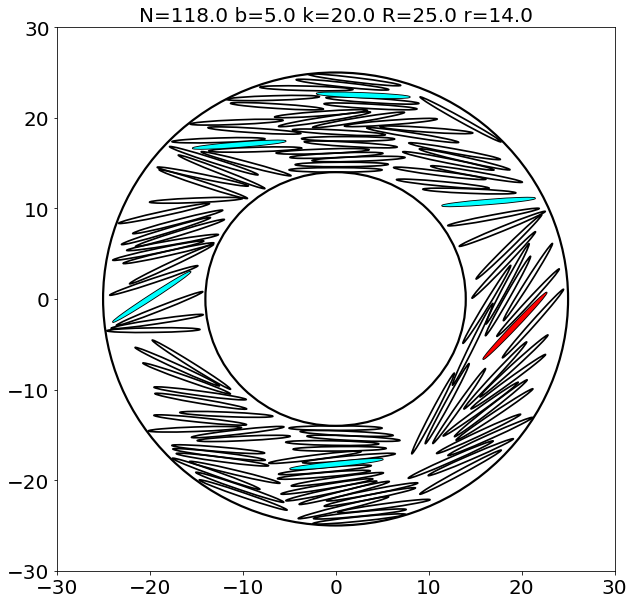

In [9]:
input_coords = test_lc_system.snapshots[19999]
fvs, ncs = create_feature_vectors_from_snapshot(input_coords, 5, 1)

print(f"Probe particle coordinates: {ncs[0]}")
for i, feature in enumerate(fvs[0]):
    print(f"{i+1}th nearest neighbor: feature = {feature}, coord = {ncs[i+1]}")

# After normalizing
print(f"Before normalizing: {fvs[0]}")
print(f"After normalizing: {fvs[0] - np.mean(fvs[0])}")
    
fig = test_lc_system.plot_snapshot(19999, extra_particles=ncs)
plt.show()

In [25]:
# number of rows AKA number of data-points
# = number of densities * (number of captures per density >= 1e6) * number of data-points per capture 
 
num_of_features = 15
num_of_samples = 8

data_matrix = []
samples = dict()

# iterate over densities
for particle_number in systems.keys():
    
    samples[particle_number] = []
    system_state_at_mc_step = systems[particle_number].snapshots
    
    # iterate over Monte Carlo steps
    for mc_step in system_state_at_mc_step.keys():
        
        if mc_step >= 5e4:
            
            # Get snapshot of system at Monte Carlo step
            snapshot = system_state_at_mc_step[mc_step]
            
            # Create the feature vectors
            feature_vecs, _ = create_feature_vectors_from_snapshot(snapshot, num_features=num_of_features, 
                                                                   num_samples=num_of_samples)
            
            # Add to PCA data matrix
            data_matrix = data_matrix + feature_vecs
            
            for fv in feature_vecs:
                samples[particle_number].append(fv)

                
data_matrix = np.stack(data_matrix, axis=0)

In [18]:
print(data_matrix[0])

[ 0.3702535   0.39635634  0.39699733 -0.49657947  0.38814706 -0.01492763
 -0.12276766  0.21132255 -0.08700794 -0.03650326 -0.5168564  -0.22743034
 -0.20541489 -0.45388478  0.39829624]


In [19]:
print(f"Shape of data matrix: {data_matrix.shape}")

Shape of data matrix: (8112, 15)


First principal component: [-0.22320639 -0.2566133  -0.19996089 -0.06106726  0.15379691  0.30237463
  0.37443224  0.38657665  0.3280689   0.19347474  0.02696469 -0.14098695
 -0.22613215 -0.2915144  -0.36620766]
Explained variance ratios: [1.7340815e-01 1.4295973e-01 7.6046295e-02 7.2448641e-02 6.9191046e-02
 6.7713171e-02 6.2647514e-02 6.1692063e-02 5.7558119e-02 5.6804195e-02
 4.7689714e-02 4.7052667e-02 4.3808565e-02 2.0980135e-02 7.3081705e-14]


Text(0.5, 1.0, 'Explained variance ratios from PCA')

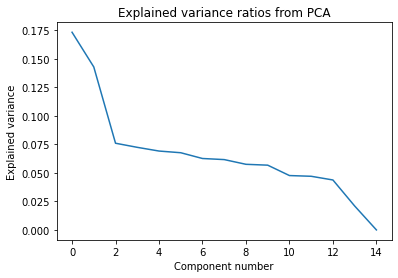

In [20]:
pca = PCA(whiten=True)
pca.fit(data_matrix)

print(f"First principal component: {pca.components_[0]}")
print(f"Explained variance ratios: {pca.explained_variance_ratio_}")

with plt.ioff():
    fig, ax = plt.subplots()
    
ax.plot(range(num_of_features), pca.explained_variance_ratio_)
ax.set_xlabel("Component number")
ax.set_ylabel("Explained variance")
ax.set_title("Explained variance ratios from PCA")

No. particles: 20.0, No. feature vectors: 792
No. particles: 40.0, No. feature vectors: 792
No. particles: 60.0, No. feature vectors: 792
No. particles: 80.0, No. feature vectors: 792
No. particles: 90.0, No. feature vectors: 792
No. particles: 100.0, No. feature vectors: 792
No. particles: 110.0, No. feature vectors: 792
No. particles: 118.0, No. feature vectors: 792
No. particles: 140.0, No. feature vectors: 688
No. particles: 160, No. feature vectors: 448
No. particles: 180, No. feature vectors: 352
No. particles: 200, No. feature vectors: 288
Critical density detected at eta = 0.34382284382284384 by PCA


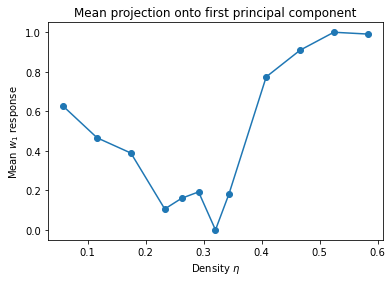

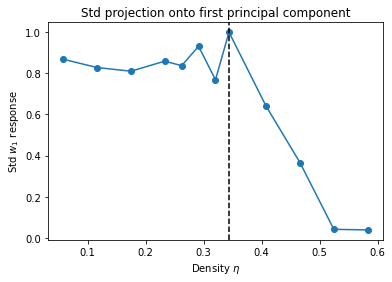

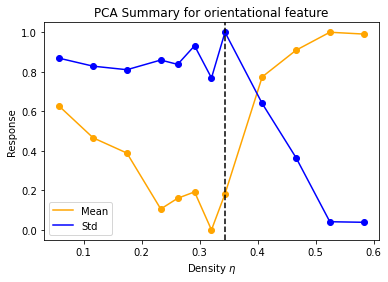

In [21]:
# Plot the response with respect to first component

w_1 = pca.components_[0]

means = []
stds = []

for particle_number in sorted(samples.keys()):
    
    fvs = samples[particle_number]
    
    print(f"No. particles: {particle_number}, No. feature vectors: {len(fvs)}")
    
    scores = [w_1 @ vec for vec in fvs]
    avg = np.mean(scores)
    std = np.std(scores)
    
    means.append(avg)
    stds.append(std)
    
# convert to numpy
means = np.array(means)
stds = np.array(stds)

# Normalize the values
norm_means = (means - min(means)) / max(means - min(means))
norm_stds = stds / max(stds)

densities = [N*a*b/(R**2-r**2) for N in sorted(samples.keys())]

critical_density = densities[np.argmax(norm_stds)]

with plt.ioff():
    mean_fig, mean_ax = plt.subplots()
    std_fig, std_ax = plt.subplots()
    all_fig, all_ax = plt.subplots()
    
### Plotting ###
mean_ax.set_xlabel(r"Density $\eta$")
mean_ax.set_ylabel(r"Mean $w_1$ response")
std_ax.set_xlabel(r"Density $\eta$")
std_ax.set_ylabel(r"Std $w_{1}$ response")
all_ax.set_xlabel(r"Density $\eta$")
all_ax.set_ylabel("Response")

mean_ax.plot(densities, norm_means)
mean_ax.scatter(densities, norm_means)
mean_ax.set_title("Mean projection onto first principal component")

std_ax.plot(densities, norm_stds)
std_ax.scatter(densities, norm_stds)
std_ax.set_title("Std projection onto first principal component")
std_ax.axvline(x=critical_density, linestyle="--", color="black")

all_ax.plot(densities, norm_means, color="orange", label="Mean")
all_ax.scatter(densities, norm_means, color="orange")
all_ax.plot(densities, norm_stds, color="blue", label="Std")
all_ax.scatter(densities, norm_stds, color="blue")
all_ax.set_title("PCA Summary for orientational feature")
all_ax.axvline(x=critical_density, linestyle="--", color="black")

all_ax.legend()
###

print(fr"Critical density detected at eta = {critical_density} by PCA")
